In [1]:
!date

Fri Oct 30 16:11:34 PDT 2020


In [121]:
import pandas as pd
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt
from scipy import stats
import os
import anndata
import matplotlib.transforms as transforms
import glob
from lazydata import track
import sys
import scanpy as sc

def nd(arr):
    return np.asarray(arr).reshape(-1)

def yex(ax):
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    return ax

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

In [3]:
gene = anndata.read_h5ad("../../data/notebook/revision/gene.h5ad")
isoform = anndata.read_h5ad("../../data/notebook/revision/isoform.h5ad")

In [4]:
gene_id = gene.var["gene_id"].values
gene_names = gene.var["gene_name"].values.astype(str)

# Formalization

In [75]:
from statsmodels.stats.multitest import multipletests
from sklearn.preprocessing import LabelEncoder
from scipy.stats import ks_2samp, ttest_ind
import numpy as np
import logging

logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.basicConfig(format='%(asctime)s - %(message)s', datefmt='%d-%b-%y %H:%M:%S')



def split_by_target(mat, targets, target, axis=0):
    """
    Split the rows of mat by the proper assignment
    
    mat = ndarray
    targets, length is equal to number of components (axis=0) or features (axis=1)
    target is a singular element from unique(assignments/features) 
    """
    if axis==0 and len(targets) != mat.shape[axis]: return -1
    if axis==1 and len(targets) != mat.shape[axis]: return -1
        
    mask = targets == target
    
    if axis==0:
        t_mat = mat[mask]  # target matrix
        c_mat = mat[~mask] # complement matrix
    elif axis==1:
        t_mat = mat[:, mask]  # target matrix
        c_mat = mat[:, ~mask] # complement matrix
    
    return (t_mat, c_mat)

def correct_pval(pval, method):
    nfeat = pval.shape[1]
    
    if method == 'benjamini-hochberg':
        _, pval_corr, _, _ = multipletests(pval, alpha=0.01, method='fdr_bh')
    elif method == 'bonferroni':
        pval_corr = np.minimum(pval * nfeat, 1.0)
        
    return pval_corr

# compute de
def dexpress(mat, components, features, assignments, **kwargs):
    """
    mat: ndarray
    components: nparray
    features: nparray
    assignments: nparray, length is equal to length of components
    """
    nan_cutoff = kwargs.get("nan_cutoff", 0)
    
    unique = np.unique(assignments)
        
    ncomp = components.shape[0]
    nfeat = features.shape[0]
    nuniq = unique.shape[0]
    
    pval = np.empty((nuniq, nfeat)) # unique assignments by features 
    pval_corr = np.empty((nuniq, nfeat)) # unique assignments by features 
    stat = np.empty((nuniq, nfeat)) # unique assignments by features 
    es = np.empty((nuniq, nfeat)) # unique assignments by features 
    
    pval.fill(np.nan)
    pval_corr.fill(np.nan)
    stat.fill(np.nan)

    for tidx, t in enumerate(unique):
        logging.info("{} of {} assignments: {}".format(tidx+1, nuniq, t))
        t_mat, c_mat = split_by_target(mat, assignments, t, axis=0)
        
        pvalue = np.nan
        statistic = np.nan
        effect_size = np.nan

        # Keep only the genes for which it is in at least nan_cutoff*ncellsinclusters
        mask = np.asarray((t_mat>0).sum(axis=0) > nan_cutoff*t_mat.shape[0]).reshape(-1)

        t_mat = t_mat[:, mask]
        c_mat = c_mat[:, mask]
        # added

        # added
        if mask.sum()>0:
            test = ttest_ind(t_mat, c_mat, nan_policy="propagate", equal_var=False)
            pvalue = test.pvalue
            statistic = test.statistic
            effect_size = nd(t_mat.mean(axis=0)) - nd(c_mat.mean(axis=0))
                
        pval[tidx,:][mask] = pvalue
        stat[tidx,:][mask] = statistic
        es[tidx,:][mask] = effect_size
    return (pval, stat, es)

def make_table(assignments, features, p_raw, p_corr, es):
    unique = np.unique(assignments)
    markers = pd.DataFrame(index=unique, columns=["name", "p_raw", "p_corr", "es"])

    for uidx, u in enumerate(unique):
        markers.loc[u]["name"] = features
        markers.loc[u]["p_raw"] = p_raw[uidx]
        markers.loc[u]["p_corr"] = p_corr[uidx]
        markers.loc[u]["es"] = es[uidx]

    markers = markers.apply(pd.Series.explode).reset_index()
    markers = markers[markers.notnull()["p_raw"]]
    return markers

In [115]:
%%time
# actual data
mat           = gene.layers["log1p"].todense()
components    = gene.obs.cell_id.values
features      = gene.var.gene_name.values
assignments   = gene.obs.class_label.values

# parameters
unique        = np.unique(assignments)
nan_cutoff    = 0.90 # of elements in cluster
corr_method   = "bonferroni"

CPU times: user 201 ms, sys: 678 ms, total: 880 ms
Wall time: 914 ms


In [119]:
p_raw, stat, es = dexpress(mat, components, features, assignments, nan_cutoff=nan_cutoff)
p_corr = correct_pval(p_raw, corr_method)

s = stat

markers = make_table(assignments, features, p_raw, p_corr, es)

# convert the 0 pvalues to the smallest possible float
markers["p_corr"][markers.eval("p_corr == 0").values] = sys.float_info.min

INFO:root:1 of 4 assignments: GABAergic
INFO:root:2 of 4 assignments: Glutamatergic
INFO:root:3 of 4 assignments: Low Quality
INFO:root:4 of 4 assignments: Non-Neuronal


In [81]:
%%time
# actual data
mat           = isoform.layers["log1p"].todense()
components    = isoform.obs.cell_id.values
features      = isoform.var.gene_name.values
assignments   = isoform.obs.class_label.values

# parameters
unique        = np.unique(assignments)
nan_cutoff    = 0.90 # of elements in cluster
corr_method   = "bonferroni"

CPU times: user 727 ms, sys: 1.89 s, total: 2.62 s
Wall time: 2.61 s


In [111]:
p_raw, stat, es = dexpress(mat, components, features, assignments, nan_cutoff=nan_cutoff)
p_corr = correct_pval(p_raw, corr_method)

s = stat

markers_isoform = make_table(assignments, features, p_raw, p_corr, es)

# convert the 0 pvalues to the smallest possible float
markers_isoform["p_corr"][markers_isoform.eval("p_corr == 0").values] = sys.float_info.min

INFO:root:1 of 4 assignments: GABAergic
INFO:root:2 of 4 assignments: Glutamatergic
INFO:root:3 of 4 assignments: Low Quality
INFO:root:4 of 4 assignments: Non-Neuronal


In [112]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

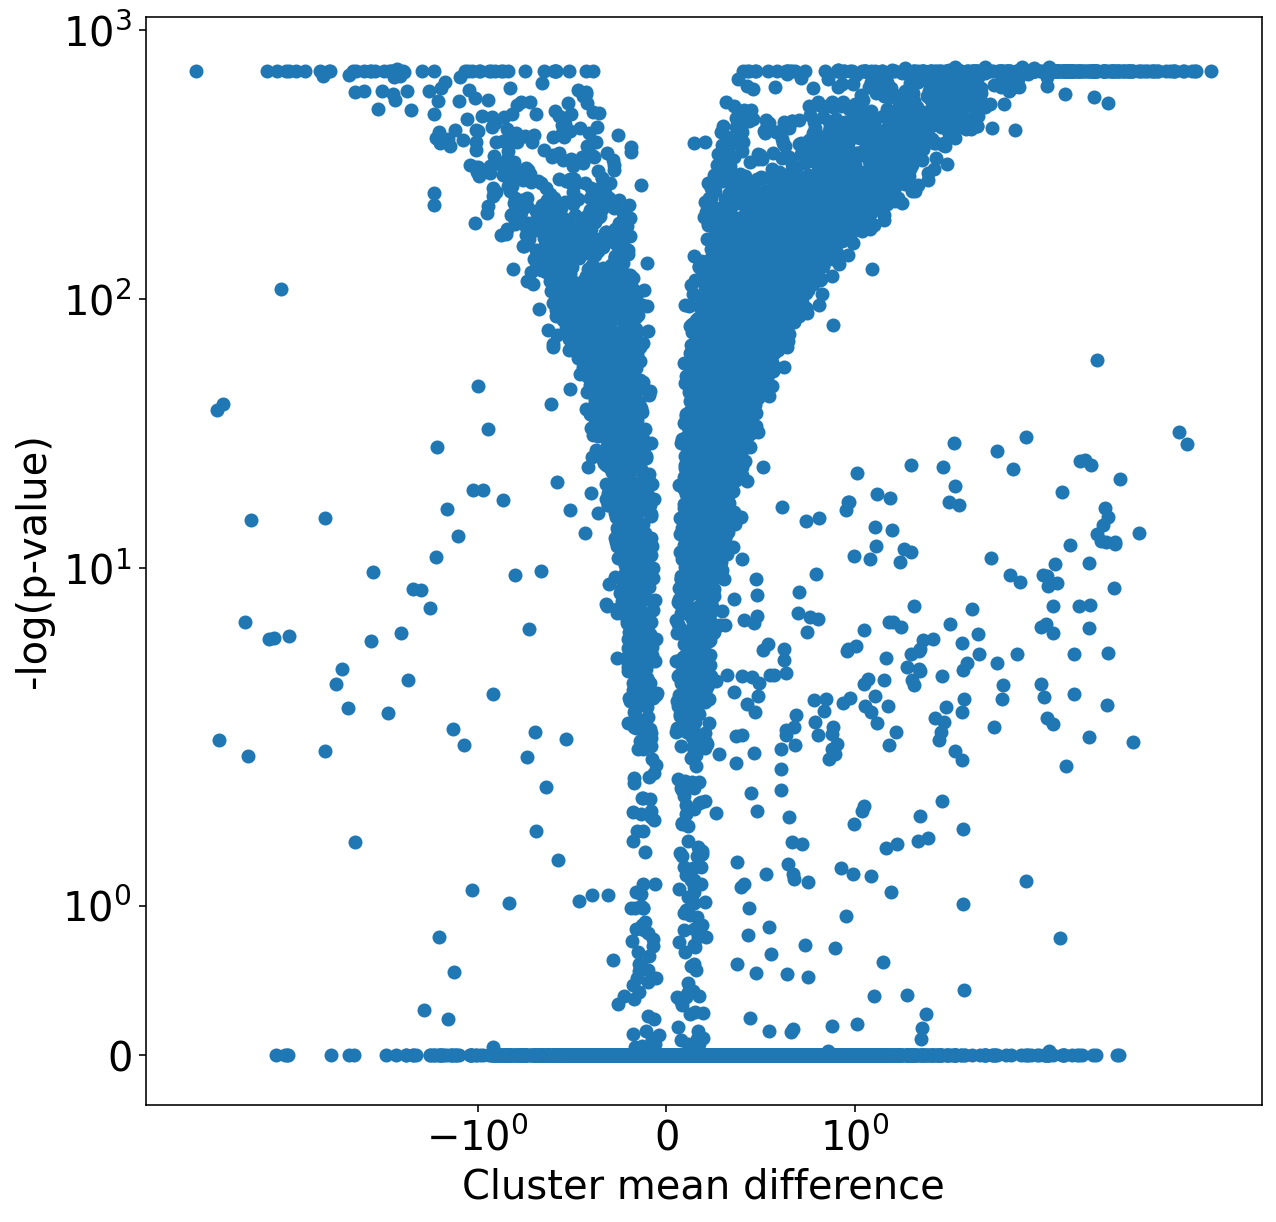

In [113]:
fig, ax = plt.subplots(figsize=(10,10))

x = markers_isoform["es"].values.astype(float)
y = -np.log(markers_isoform["p_corr"].values.astype(float))

ax.scatter(x,y, label="isoform", zorder=10)

ax.set(**{
    "xscale": "symlog",
    "yscale": "symlog",
    "xlabel": "Cluster mean difference",
    "ylabel": "-log(p-value)"
})

fig.show()

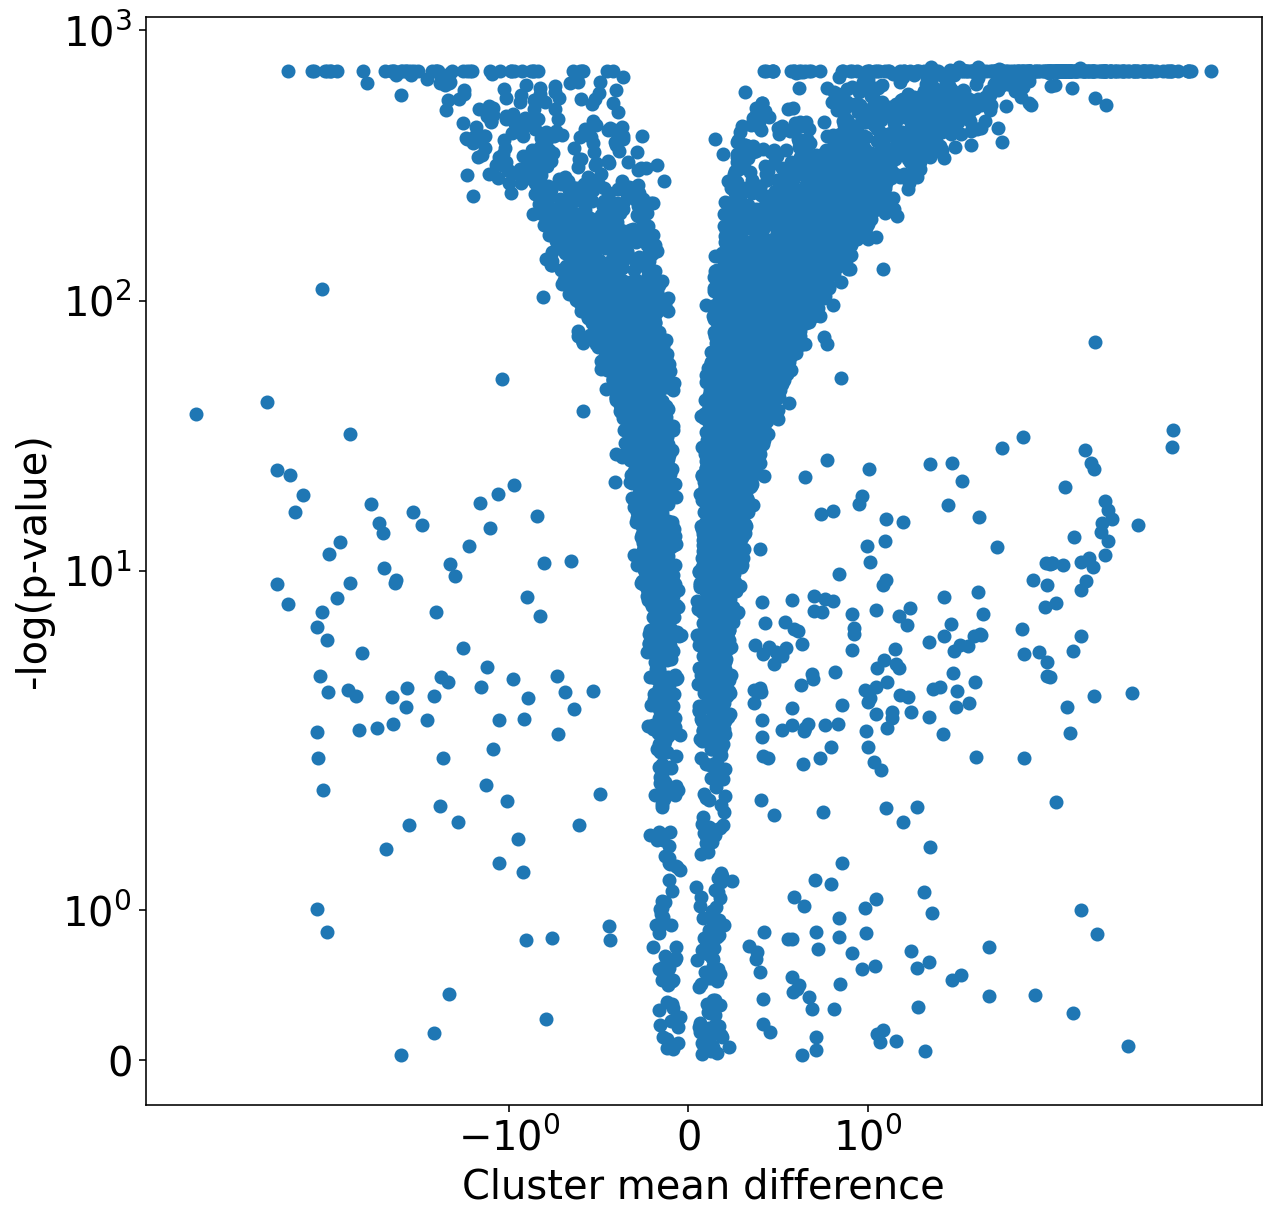

In [120]:
fig, ax = plt.subplots(figsize=(10,10))

e = markers["es"].values.astype(float)
p = markers["p_corr"].values.astype(float)

mask = p<1
x = e[mask]
y = -np.log(p[mask])

ax.scatter(x,y, label="gene", zorder=10)

ax.set(**{
    "xscale": "symlog",
    "yscale": "symlog",
    "xlabel": "Cluster mean difference",
    "ylabel": "-log(p-value)"
})

fig.show()